# COGS 108 - Final Project 
## Group 034

# Overview

In this project we analyzed youtube trending data of over the course of six months to figure out what the main factors are for a video's popularity. We did data scraping to acquire the lengths of the videos and data cleaning for removing dupilcates and invalid videos. We then used statistical tools to determine the influence of different features on the popularity of a youtube video.

# Names

- Ziyi Ye
- Gaurav Parmar
- Wendy Li
- Ziyang Zhang
- Yiyun Zhang

#### Group Members IDs

- A14684370
- A13947003
- A15015655
- A15222248
- A15108406

# Research Question

What are the main factors influencing the popularity of a youtube video? Is it possible to estimate the popularity of a video based on its title, category, length, etc.? In this project, we aim to examine the metadata of the videos and its relationship to the popularity trends within several video categories. 

## Background and Prior Work

Youtube is a world-famous video-sharing website on which hundreds of thousands of full-time Youtubers devote their full attention to creating content. The popularity of videos, quantified as viewing statistics, are directly related to these professional Youtubers’ income and career paths. Popular videos are generated daily within each category, yet a clearly defined approach to producing such popular videos remains unclear. As a result, a model that could predict a given video’s popularity is extraordinarily useful for anyone interested in starting their own YouTube channel. It could also give us some insights into the social impact of YouTube, social media, and video hosting websites in general.

In an article from DIGIDAY, Gwen Miller, VP of content strategy at digital video network Kin Community, indicates that 10 to 16 minutes has become the length of most popular YouTube videos. However because the Youtube algorithm gives YouTubers more income once if they create longer content and insert more ads, catching viewer retention at the same time, more and more YouTubers start to create content which exceeds 12 minutes. Though Miller does not consider dividing the different lengths by categories of videos, they are still considered to be useful for our project as a reference once the research starts. (1)

Trending youtube data has been used to conduct analyses into a few different topics such as: content of video titles, views/likes/dislikes/comment correlation, most popular video category,  category of channel with most trending videos, etc.. Youtube data was also compared between different countries to see what similarities or differences existed between youtube video consumption. Some examples of findings include: entertainment videos were the most popular video type in most countries and videos in the US and UK had the longest enduring trending videos. (2)





(1) Peterson, T. (2018, July 3). Retrieved from https://digiday.com/media/creators-making-longer-videos-cater-youtube-algorithm/.

(2) Kaggle Dataset: https://www.kaggle.com/datasnaek/youtube-new



# Hypothesis


We hypothesize that certain features of the video such as the length of the videos, the title choice and the publish time have an unproportionally large influence on its popularity. Therefore, we wonder if the metadata can accurately estimate the video’s popularity irrespective of its content. 


# Dataset(s)


We used a relatively new dataset from a Kaggle challenge titled “Trending YouTube Video Statistics”, which contains features such as views, likes, dislikes, comments, tags and categories of the video. (https://www.kaggle.com/datasnaek/youtube-new). This dataset does not contain the length of the videos so we queried those from the youtub APIs.

- Dataset Name: Trending YouTube Video Statistics
- Link to the dataset: https://www.kaggle.com/datasnaek/youtube-new
- Number of observations: 


# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import patsy
import statsmodels.api as sm
import seaborn as sns
import requests
import sys
import json
from scipy.stats import pearsonr
from datetime import datetime
import re
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from IPython.display import Image as Image_d
from scipy import stats
import nltk
import re
import operator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.stats import ttest_ind,normaltest
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/Frank/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Frank/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Cleaning & Pre-processing

## Acquiring video lengths

We first acquired the length of the videos using the youtube API. In the following cell, we turned the dataset on kaggle into a new length.csv file that contains three new columns: hour, min and sec all start with -1 indicating they have not been acquired yet.

In [2]:
"""
US_videos = pd.read_csv('./youtube-new/USvideos.csv')
row = US_videos.shape[0]
hour = np.repeat(-1, row)
min = np.repeat(-1, row)
sec = np.repeat(-1, row)

# -1 not scraped, 0 0 0 means not available
US_videos['hour'] = hour
US_videos['min'] = min
US_videos['sec'] = sec

US_videos.to_csv(r'length.csv', index=False, line_terminator='\r\n')
"""


"\nUS_videos = pd.read_csv('./youtube-new/USvideos.csv')\nrow = US_videos.shape[0]\nhour = np.repeat(-1, row)\nmin = np.repeat(-1, row)\nsec = np.repeat(-1, row)\n\n# -1 not scraped, 0 0 0 means not available\nUS_videos['hour'] = hour\nUS_videos['min'] = min\nUS_videos['sec'] = sec\n\nUS_videos.to_csv(r'length.csv', index=False, line_terminator='\r\n')\n"

The following function is used to query the youtube api with a video id and returns a string representation of the length of the video.

In [3]:
def get_length(video_id):
    searchUrl = "https://www.googleapis.com/youtube/v3/videos?id=" + \
        video_id+"&key="+api_key+"&part=contentDetails"

    request = requests.get(searchUrl)
    if request.status_code == 429:
        print("Temp-Banned due to excess requests, please wait and continue later")
        sys.exit()

    data = request.json()
    if 'items' not in data:
        print(data)
        return "Error"
    return data['items'][0]['contentDetails']['duration']

The following is the standardization function to standardize the string representation of the length the youtube API returns to a tuple of hour, minute and seconds. Youtube API returns a string in the format of "PT?H?M?S" but may not have all the characters H,M and S. For example, it may be "PT1H1S" if it's one hour and one seconds long.

In [4]:
def standardize_length(input):
    hour = 0
    min = 0
    sec = 0

    input = input.replace('PT', '')
    input = input.upper()
    if 'H' in input:
        hour = input.split('H')[0]
        input = input.split('H')[1]
    if 'M' in input:
        min = input.split('M')[0]
        input = input.split('M')[1]
    if 'S' in input:
        sec = input.split('S')[0]
        input = input.split('S')[1]
    return hour, min, sec

Since there's a daily quota limit to the youtube API we can use, the following cell in run multiple time over the course of a week with different api keys to fill in the lengths of the videos. Hour, minute and second are all set to zero if a video's length is not available. This may happen when the video is no longer available on youtube or it's a livestream video. Running the cell directly will cause an error since the api keys are not included in this directory.

In [5]:
"""
with open('./api_keys/YOURAPI.txt', 'r') as file:
    api_key = file.readline()

US_videos = pd.read_csv('./length.csv')
row = US_videos.shape[0]
hour = np.repeat(-1, row)
min = np.repeat(-1, row)
sec = np.repeat(-1, row)

# -1 not scraped, 0 0 0 means not available

unavailable_count = 0
dailyNum = 7000
startIndex = 0
first = True
stop = 0

# find start Index

for i, r in US_videos.iterrows():

    if r['hour'] == -1:
        startIndex = i
        break
    else:
        hour[i] = r['hour']
        min[i] = r['min']
        sec[i] = r['sec']


# startIndex = 0
print(startIndex)

for i, r in US_videos[startIndex: startIndex + dailyNum].iterrows():

    curr_id = r['video_id']

    # some videos are unavailable such as: n30k5CwLhS4
    try:

        if curr_id == '#NAME?' or curr_id == '#VALUE!':
            hour[i] = 0
            min[i] = 0
            sec[i] = 0
            unavailable_count += 1
            continue

        length = get_length(curr_id)

        if length == 'Error':
            print('stopping at: ', i)
            stop = i
            break

        hour[i], min[i], sec[i] = standardize_length(length)

        if i % 1000 == 0:
            print('saving ', startIndex, ' to ', i, 'to disk')
            US_videos['hour'] = hour
            US_videos['min'] = min
            US_videos['sec'] = sec
            US_videos.to_csv(r'length.csv', index=False,
                             line_terminator='\r\n')
    except IndexError:
        hour[i] = 0
        min[i] = 0
        sec[i] = 0
        unavailable_count += 1
    except:  # live stream videos
        hour[i] = 0
        min[i] = 0
        sec[i] = 0
        unavailable_count += 1
        print('unexpected error(possibly live stream video)')


print('unavailable videos', unavailable_count)

US_videos['hour'] = hour
US_videos['min'] = min
US_videos['sec'] = sec

if stop == 0:
    stop = startIndex + dailyNum
print(US_videos[stop - 5:stop + 5])
US_videos.to_csv(r'length.csv', index=False, line_terminator='\r\n')
"""

"\nwith open('./api_keys/YOURAPI.txt', 'r') as file:\n    api_key = file.readline()\n\nUS_videos = pd.read_csv('./length.csv')\nrow = US_videos.shape[0]\nhour = np.repeat(-1, row)\nmin = np.repeat(-1, row)\nsec = np.repeat(-1, row)\n\n# -1 not scraped, 0 0 0 means not available\n\nunavailable_count = 0\ndailyNum = 7000\nstartIndex = 0\nfirst = True\nstop = 0\n\n# find start Index\n\nfor i, r in US_videos.iterrows():\n\n    if r['hour'] == -1:\n        startIndex = i\n        break\n    else:\n        hour[i] = r['hour']\n        min[i] = r['min']\n        sec[i] = r['sec']\n\n\n# startIndex = 0\nprint(startIndex)\n\nfor i, r in US_videos[startIndex: startIndex + dailyNum].iterrows():\n\n    curr_id = r['video_id']\n\n    # some videos are unavailable such as: n30k5CwLhS4\n    try:\n\n        if curr_id == '#NAME?' or curr_id == '#VALUE!':\n            hour[i] = 0\n            min[i] = 0\n            sec[i] = 0\n            unavailable_count += 1\n            continue\n\n        length 

## Preprocessing and data wrangling

After acquiring all the lengths of the videos, we stored the data in "US_length.csv" and read that into a dataframe.

In [6]:
US_videos = pd.read_csv('US_length.csv')
US_videos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,hour,min,sec
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,0,11,18
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",0,23,51
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,0,9,29
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,0,7,10
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,0,12,13


We get the length of titles and the number of capital letters and store those in separate columns.

In [7]:
US_videos['title_length'] = US_videos['title'].str.len()
US_videos['num_of_upper'] = US_videos['title'].str.findall(r'[A-Z]').str.len()

One more thing we need to do is to transform the trending date to datetime format for plotting.

In [8]:
US_videos['trending_date'] = pd.to_datetime(US_videos['trending_date'], format='%y.%d.%m')

We then calculate the total number of seconds and store them in a new column and remove the hour, min and sec columns.

In [9]:
secs = US_videos['sec'].values
mins = US_videos['min'].values
hours = US_videos['hour'].values
total_time = [s+60*m+3600*h for s,m,h in zip(secs, mins, hours)]
US_videos['total_time'] = total_time
US_videos = US_videos.drop(['sec', 'min', 'hour'], axis = 1)

The same video may be on the trending list multiple times. Let's sort the dataframe in terms of title length and the title so see if there are duplicates.

In [10]:
sorted_videos = US_videos.sort_values(['title_length', 'title']).set_index(['title_length', 'title'])
sorted_videos.head()

video_id trending_date  channel_title  category_id  \
title_length title                                                          
4            Jack   A9YcrloL3oE    2018-02-22  Unbox Therapy            1   
             Jack   A9YcrloL3oE    2018-02-23  Unbox Therapy            1   
             Jack   A9YcrloL3oE    2018-02-24  Unbox Therapy            1   
             Jack   A9YcrloL3oE    2018-02-25  Unbox Therapy            1   
             Jack   A9YcrloL3oE    2018-02-26  Unbox Therapy            1   

                                publish_time  \
title_length title                             
4            Jack   2018-02-21T22:29:33.000Z   
             Jack   2018-02-21T22:29:33.000Z   
             Jack   2018-02-21T22:29:33.000Z   
             Jack   2018-02-21T22:29:33.000Z   
             Jack   2018-02-21T22:29:33.000Z   

                                                                 tags  \
title_length title                                                      
4            Jack   unbox therapy|"unbox"|"therapy"|"jack"|"unbox ...   
             Jack   unbox therapy|"unbox"|"therapy"|"jack"|"unbox ...   
             Jack   unbox therapy|"unbox"|"therapy"|"jack"|"unbox ...   
             Jack   unbox therapy|"unbox"|"therapy"|"jack"|"unbox ...   
             Jack   unbox therapy|"unbox"|"therapy"|"jack"|"unbox ...   

                      views   likes  dislikes  comment_count  \
title_length title                                             
4            Jack   1234544  170540      4176          26091   
             Jack   2911713  247646      7615          34728   
             Jack   3239660  262437      7931          36404   
             Jack   3406316  269528      8189          36280   
             Jack   3497916  273181      8342          36731   

                                                    thumbnail_link  \
title_length title                                                   
4            Jack   https://i.ytimg.com/vi/A9YcrloL3oE/default.jpg   
             Jack   https://i.ytimg.com/vi/A9YcrloL3oE/default.jpg   
             Jack   https://i.ytimg.com/vi/A9YcrloL3oE/default.jpg   
             Jack   https://i.ytimg.com/vi/A9YcrloL3oE/default.jpg   
             Jack   https://i.ytimg.com/vi/A9YcrloL3oE/default.jpg   

                    comments_disabled  ratings_disabled  \
title_length title                                        
4            Jack               False             False   
             Jack               False             False   
             Jack               False             False   
             Jack               False             False   
             Jack               False             False   

                    video_error_or_removed  \
title_length title                           
4            Jack                    False   
             Jack                    False   
             Jack                    False   
             Jack                    False   
             Jack                    False   

                                                          description  \
title_length title                                                      
4            Jack   This wasn't easy for Jack to do... He did it f...   
             Jack   This wasn't easy for Jack to do... He did it f...   
             Jack   This wasn't easy for Jack to do... He did it f...   
             Jack   This wasn't easy for Jack to do... He did it f...   
             Jack   This wasn't easy for Jack to do... He did it f...   

                    num_of_upper  total_time  
title_length title                            
4            Jack              1         229  
             Jack              1         229  
             Jack              1         229  
             Jack              1         229  
             Jack              1         229

As we can see, the video titled "Jack" is on the trending list multiple times.We therefore remove the duplicate videos and keep only the video with the highest view count among those. We also save the original dataframe with duplicates in a separate dataframe to do further analysis.

In [11]:
duplicate = US_videos

In [12]:
uniq = US_videos['title'].unique()

df_extract = pd.DataFrame()
for i in uniq:
    cur_df = US_videos.loc[US_videos['title'] == i]
    max_view = max(cur_df['views'].tolist())
    cur_df = cur_df[cur_df.views == max_view]
    df_extract = df_extract.append(cur_df, sort=False,ignore_index=True)
US_videos = df_extract
print("Done removing duplicates")

Done removing duplicates


For the publish time, we want to know what time of the day a video is uploaded, so we format the string of the publish time which looks like "2017-11-13T17:13:01.000Z" into a single integer(17) representing the hour of the day it's published and store them in the same column.

In [13]:
publish_time = [int(s.split('T')[1].split(':')[0]) for s in US_videos['publish_time'].values]
US_videos['publish_time'] = publish_time

Now let's take a look at the cleaned dataframe.

In [14]:
US_videos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,title_length,num_of_upper,total_time
0,2kyS6SvSYSE,2017-11-20,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,17,SHANtell martin,2564903,96321,7972,22149,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,34,28,678
1,1ZAPwfrtAFY,2017-11-20,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,7,"last week tonight trump presidency|""last week ...",6109402,151250,11508,19820,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",62,11,1431
2,5qpjK5DgCt4,2017-11-20,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,19,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",5315471,187303,7278,9990,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,53,8,569
3,puqaWrEC7tY,2017-11-20,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,11,"rhett and link|""gmm""|""good mythical morning""|""...",913268,16729,1386,2988,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,32,4,430
4,d380meD0W0M,2017-11-19,I Dare You: GOING BALD!?,nigahiga,24,18,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2819118,153395,2416,20573,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,24,12,733


# Data Visualization

 First we try to see how many trending videos per day are in this dataset. It can be seen that the dataset has about 200 videos per day to begin with, but after removing those duplicates, there are only less than half of the videos per day.

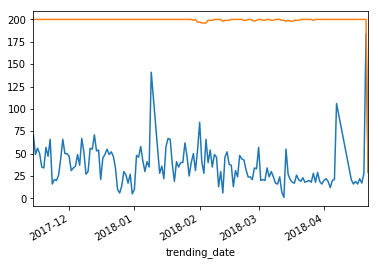

In [15]:
US_videos['trending_date'].groupby((US_videos["trending_date"])).count().plot()
duplicate['trending_date'].groupby((duplicate["trending_date"])).count().plot()

Then we make a scatter plots of the features to get a visual understanding of the data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c217aa358>,
      dtype=object)

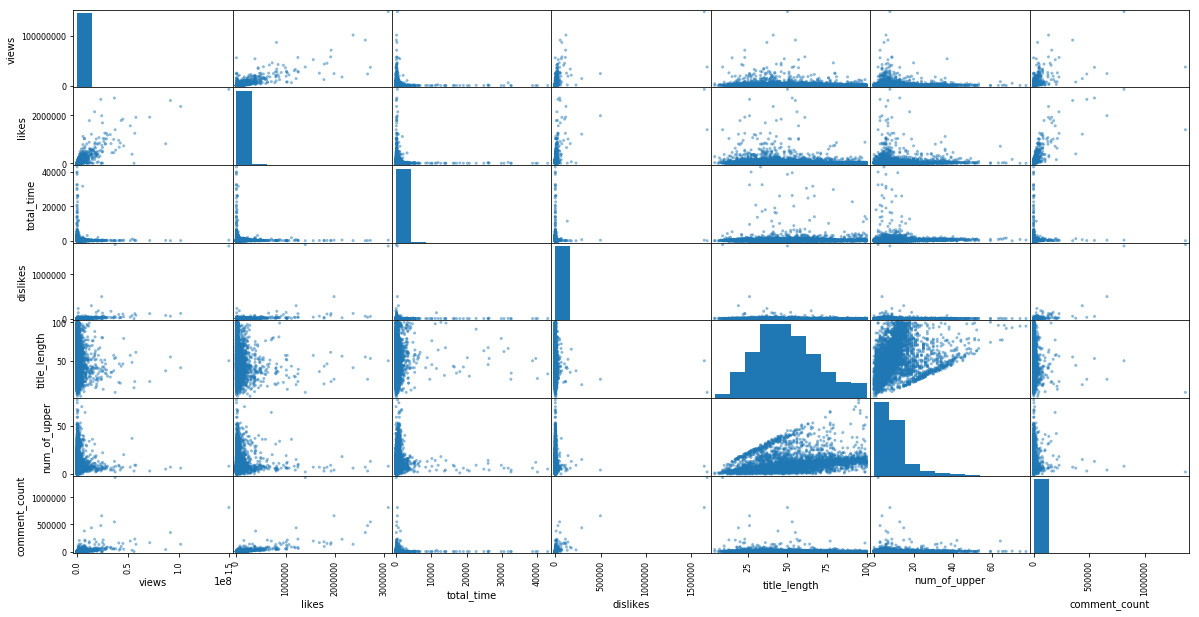

In [16]:
pd.plotting.scatter_matrix(US_videos[['views', 'likes', 'total_time', 'dislikes', 'title_length', 'num_of_upper','comment_count']],figsize=(20,10))

We can see some positive correlations between features such as comment_count and the number of views. This provides a general visual understanding of the data but we'll dive into features we care about in detail.

Before investigating the features, we need to provide a definition of popularity. Therefore we make the following scatter plots for the metrics that indicate popularity of the videos. 

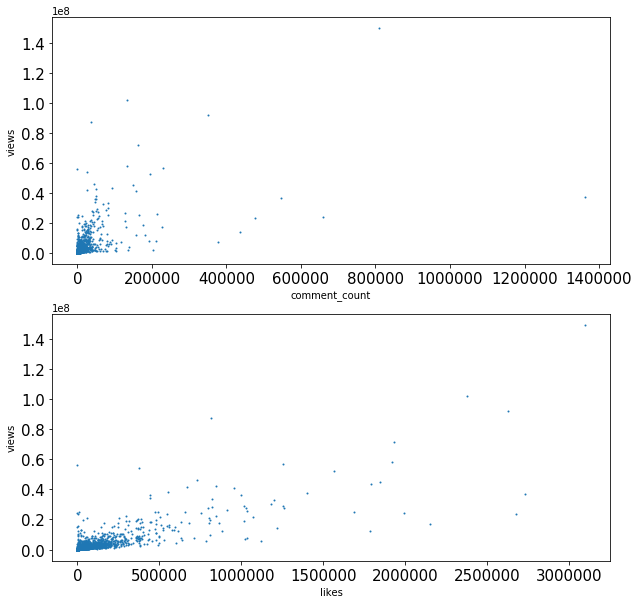

In [17]:
df = US_videos
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (10,10))
df.plot(kind = 'scatter', x='comment_count', y='views', ax = axes[0], fontsize = 15, s=1)
df.plot(kind = 'scatter', x='likes', y='views', ax = axes[1], fontsize = 15, s = 1)

We do a log transform of the views for a better scale.

In [18]:
US_videos['logViews'] = np.log(US_videos['views'])
US_videos['logComments'] = np.log(US_videos['comment_count'])
US_videos['logLikes'] = np.log(US_videos['likes'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


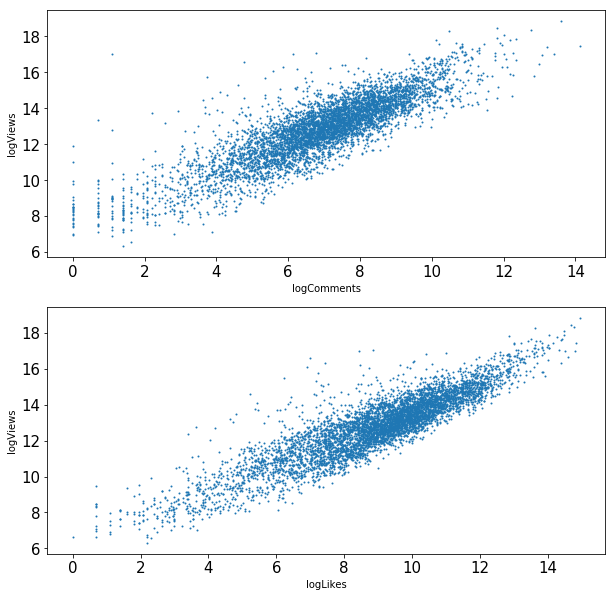

In [19]:
df = US_videos
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (10,10))
df.plot(kind = 'scatter', x='logComments', y='logViews', ax = axes[0], fontsize = 15, s=1)
df.plot(kind = 'scatter', x='logLikes', y='logViews', ax = axes[1], fontsize = 15, s = 1)

As we can see, the likes, views and comment count are very correlated. This is also expected since videos with higher views typically have higher likes and comment counts(unless comment is disabled). Therefore in our future analysis, we are just using views as an indicator of the popularity of the videos.

Now we investigate into what features are correlated with the popularity of the videos. So we will take a closer look at the following features:
1. Total length of the video
2. Total length of the title 
3. The time at which the video is uploaded 
4. The number of capital letters in the title 


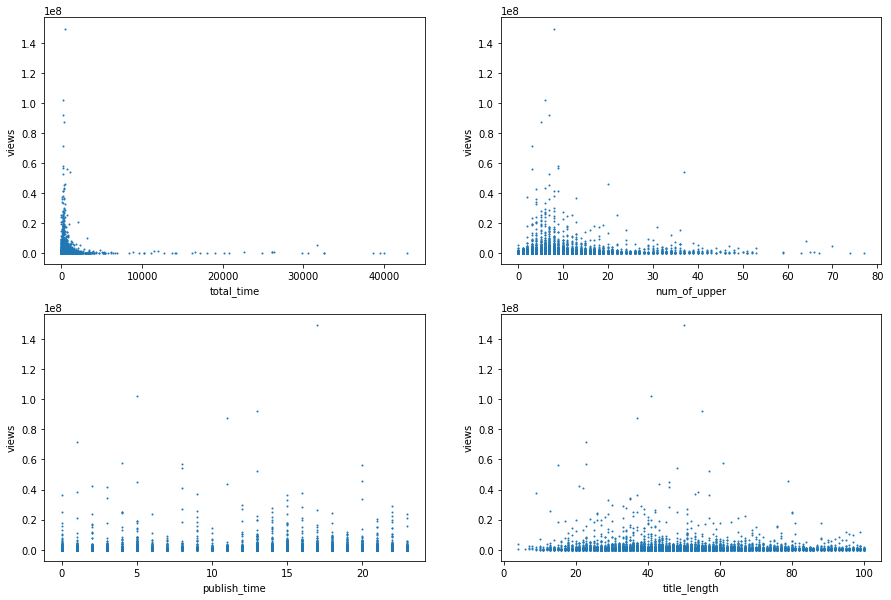

In [50]:
fig, axes = plt.subplots(nrows = 2, ncols=2, figsize = (15,10))
US_videos.plot.scatter(ax=axes[0,0], x='total_time', y='views', s =1)
US_videos.plot.scatter(ax=axes[0,1], x='num_of_upper', y='views', s =1)
US_videos.plot.scatter(ax=axes[1,0], x='publish_time', y='views', s =1)
US_videos.plot.scatter(ax=axes[1,1], x='title_length', y='views', s =1)

This gives a general idea of how the features are related to the views of a video. 
- for the total_time of the video, we can see that long videos(longer than 10000 seconds) typically are not very popular and the videos with a lot of views typically are relatively short.
- for the number of capital letters in the title, there's peak around 8 characters that have a lot of view counts.
- for the publish time, there does not seem to have a significant correlation with the popularity of the video. There are a couple outliers but the videos published at different hours of the day can all have relatively large views.
- for the view counts and the title length, there also does not seem be a strong relation between the two.

However, in the scatter plots we cannot see how many points belong to a certain range in the x-axis and we cannot determine what's the most frequent title_length, publish_time, etc. among trending videos. Therefore we now go into each of these features in detail in the following analysis.

### total_time 

We will first examine the "total_time" feature, which is the length of a video. Let's first create a histogram for the total number of seconds.

Text(0.5, 0, 'total_time')

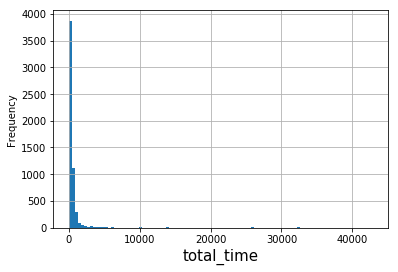

In [51]:
US_videos['total_time'].plot.hist(bins= 100,grid=True)
plt.xlabel("total_time", fontsize=15)

Many videos seems to have nearly 0 lengths. Let's quantify how many videos have 0 second length, which means the length is not valid.

In [53]:
print('total number of videos: ', US_videos.shape[0])
print('video with 0 length: ', US_videos[US_videos['total_time'] == 0].shape[0])

total number of videos:  5567
video with 0 length:  340


It turns out that only less than 10 percent of the videos have 0 seconds length. The result in the previous graph is because some videos have very long lengths compared to other. Therefore we remove the videos with 0 lengths and do a log transformation of the lengths.

We check the number of videos with different title lengths and the result shows that videos with title lengths of around 40-60 characters are most common among trending videos. We are not using a histogram since we want to capture the number of videos for all title_lengths and the number of charactesr is a discrete number.

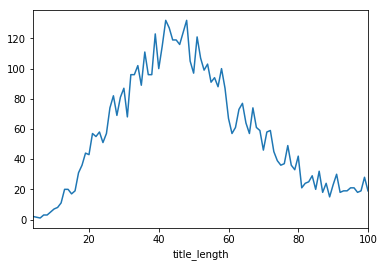

In [23]:
US_videos['title_length'].groupby(US_videos['title_length']).count().plot()

### We then check the distributions of the number of upper case letters in the videos.

Again we are not using histogram because we want to capture all the data points.

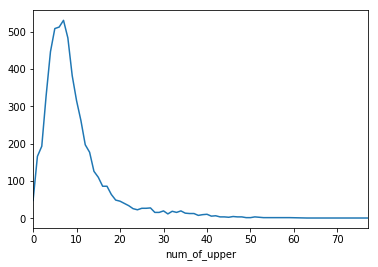

In [24]:
US_videos['num_of_upper'].groupby(US_videos['num_of_upper']).count().plot()

It's obvious that the function peaks around 8 upper characters in the title. Let's look at the distribution of ratio of the upper letter characters in the entire title. We made both a line plot and a histrogram for better understanding of the data.

Text(0.5, 0, 'ratio of captial letters')

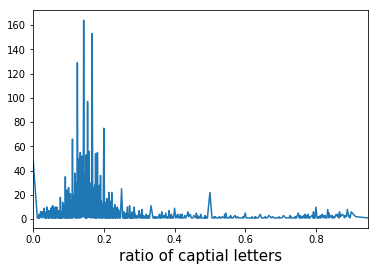

In [25]:
ratio = US_videos['num_of_upper']/US_videos['title_length']
ratio.groupby(ratio).count().plot()
plt.xlabel("ratio of captial letters", fontsize=15)

Text(0.5, 0, 'ratio of captial letters')

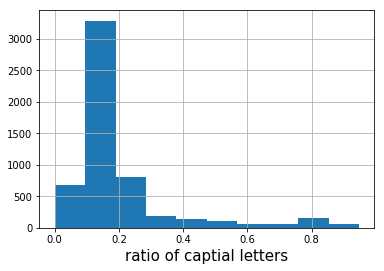

In [26]:
ratio.hist(bins = 10)
plt.xlabel("ratio of captial letters", fontsize=15)

It can be seen that there are around 40 videos that do not use captial letters and most videos have a ratio of 0.1 to 0.2 of capital letters in there titles. There are also a few that use almost all captical letters, indicated by the small peak around 0.8 in the histogram.

### Next, we want to further visualize the publish time feature in addition to the scatterplot.

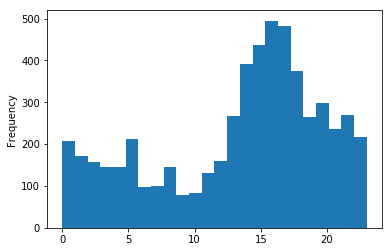

In [27]:
US_videos['publish_time'].plot.hist(bins = 24)


TODO: Seems like there is a peak. Maybe some analysis as well?

### Finally, let's look at how title length correlate with popularity

From figure 1, apparently if we use linear regression to analyze title length v.s. view count, we will not get a meaningful result. Therefore, we can assume that unlike other features, title length does not contribute much towards the popularity of a YouTube vide.
Therefore, we did other analysis regarding to the content of YouTube video titles in following section of "Word Choice in Title".

# Data Analysis & Results

## Average lengths of trending videos over time.

We then check the average lengths of videos each day and plot that length over time to see if there's trend. Here we are using the dataframe without removing the duplicates.

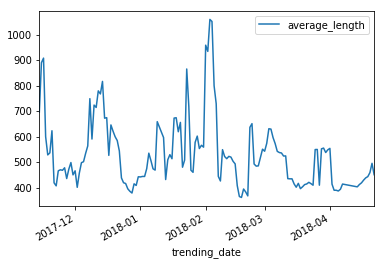

In [28]:
lengthOverTime = pd.DataFrame(index = duplicate['trending_date'].groupby((duplicate['trending_date'])).count().index, columns =['average_length']) 
for date, r in lengthOverTime.iterrows():
    curr_length = duplicate[duplicate['trending_date'] == date]['total_time']
    curr_length = curr_length[curr_length != 0]
    average_length = sum(curr_length) /  curr_length.count()
    lengthOverTime['average_length'][date] = average_length
lengthOverTime.plot()

In [29]:
length_arr = lengthOverTime['average_length'].to_numpy()
r, p = pearsonr(length_arr.astype(np.float64), np.arange(0, np.size(length_arr)))
r,p

(-0.2724783650093921, 0.0006835316762581829)

As we can see, there's slight decreasing trend in the the average lengths over the six months. The decreasing rate is relatively small and there are fluctuations, but the small p-value indicates a statistically significant decreasing trend overtime.

## Linear regression model for popularity of a video

As shown in the data visualization section, the views of a video is strongly correlated with likes and comment counts, and therefore in this section we are just using the number of views of a video as an indicator for the popularity of a video.

In order to analyze the relationship between the popularity of a video (in this case we are using the views as an indicator), we create linear models to predict the views of a video from the length of the videos and the length of the title. 

We drop all the videos with zero lengths and store them in a new dataframe.

In [30]:
US_videos_valid_length = US_videos[US_videos['total_time'] != 0]

Here we do a regression of the popularity of videos with the length of the titles.

                            OLS Regression Results                            
Dep. Variable:               logViews   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     22.82
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           1.82e-06
Time:                        10:33:46   Log-Likelihood:                -11265.
No. Observations:                5567   AIC:                         2.253e+04
Df Residuals:                    5565   BIC:                         2.255e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       13.0614      0.067    195.182   

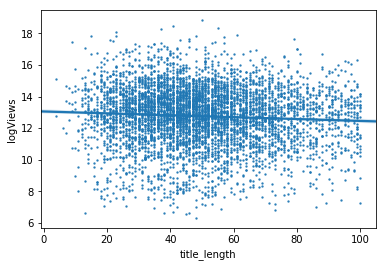

In [31]:
outcome, predictors = patsy.dmatrices('logViews ~ title_length', US_videos)

mod = sm.OLS(outcome, predictors)
res = mod.fit()

# Print out the summary results of the model fitting
print(res.summary())

sns.regplot(x='title_length', y='logViews', data=US_videos,scatter_kws={'s':2})

It turns out there's a statiscally significant negative relationship between the title length of the popularity, but this explains very little(0.005) of the difference in views.

We run a OLS regression on the log of the view counts and the lengths of the video.

                            OLS Regression Results                            
Dep. Variable:               logViews   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.685
Date:                Sun, 08 Dec 2019   Prob (F-statistic):            0.00559
Time:                        10:33:46   Log-Likelihood:                -10544.
No. Observations:                5227   AIC:                         2.109e+04
Df Residuals:                    5225   BIC:                         2.111e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.8010      0.026    487.723      0.0

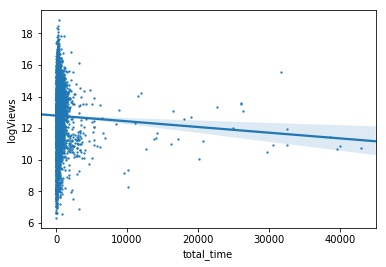

In [32]:
outcome, predictors = patsy.dmatrices('logViews ~ total_time', US_videos_valid_length)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())
sns.regplot(x='total_time', y='logViews', data=US_videos_valid_length,scatter_kws={'s':2})

It can be seen that there's a fairly significant negative relationship between the views and the lengths of the video (p-value is 0.6%), but the R-squared value is 0.001 so the lengths of the video explains very little for the difference in the views. 

There are some outliers in the graph that certainly skewed the regression. There are a couple very long videos. We removed the outliers videos and run the regression again.

                            OLS Regression Results                            
Dep. Variable:               logViews   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.682
Date:                Sun, 08 Dec 2019   Prob (F-statistic):              0.102
Time:                        10:33:47   Log-Likelihood:                -10421.
No. Observations:                5163   AIC:                         2.085e+04
Df Residuals:                    5161   BIC:                         2.086e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.7537      0.035    369.620      0.0

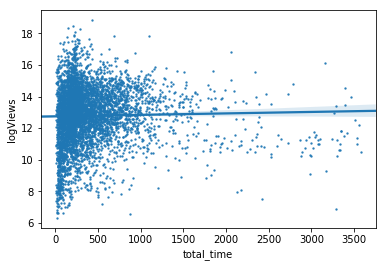

In [33]:
outcome, predictors = patsy.dmatrices('logViews ~ total_time', US_videos_valid_length[US_videos_valid_length['total_time'] < 3600])
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())
sns.regplot(x='total_time', y='logViews', data=US_videos_valid_length[US_videos_valid_length['total_time'] < 3600],scatter_kws={'s':2})

The regression model shown above is for all videos of length less than 3600 seconds (1 hour) and it turns out there's very little relationship between the length of the videos and the popularity in this regression.

                            OLS Regression Results                            
Dep. Variable:               logViews   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     118.5
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           3.12e-27
Time:                        10:33:47   Log-Likelihood:                -8365.2
No. Observations:                4116   AIC:                         1.673e+04
Df Residuals:                    4114   BIC:                         1.675e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.2275      0.056    219.008      0.0

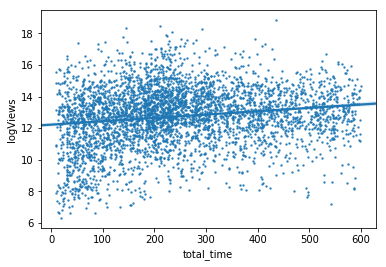

In [34]:
outcome, predictors = patsy.dmatrices('logViews ~ total_time', US_videos_valid_length[US_videos_valid_length['total_time'] < 600])
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())
sns.regplot(x='total_time', y='logViews', data=US_videos_valid_length[US_videos_valid_length['total_time'] < 600],scatter_kws={'s':2})

The regression model shown above is for all videos of length less than 600 seconds (10 minutes) and there's a statistically significant positive relationship between the views and the lengths of the videos. The R-square is still fairly small, so the lengths of the videos do not explain much about the difference of the popularity. 

## Word choices in title

In this section, we use all words appeared in titles of given cleaned trending video dataFrame to conduct a word cloud images, given a visually impression of what words are the most popular, or most attracting ones.

Because there are many non-alphabetic words among titles in the dataset, we first cleaned everything non-alphabetic. To maximize the functionability of the world cloud to provide a more meaningful result, we then eliminated all transition words, abjective words and other words that do not mean anything by using wordCloud packages from ULTK.

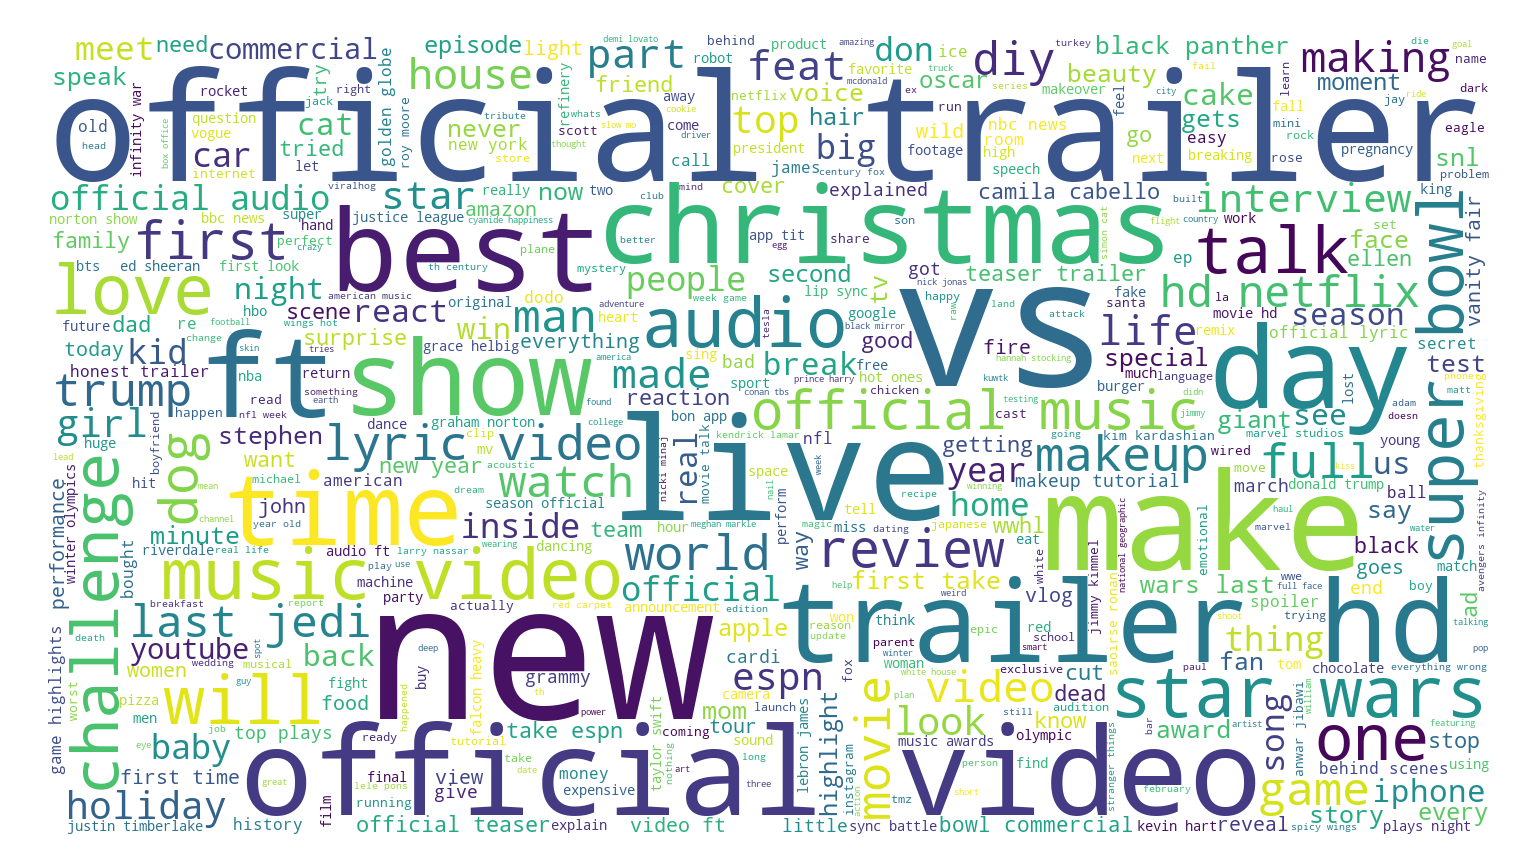

In [35]:
df = US_videos
titleLst = df['title'].tolist()

for i in range(len(titleLst)):
    new = re.sub(r"’", '', titleLst[i])
    titleLst[i] = re.sub(r'[^a-zA-Z_]', ' ', new)

with open('titles_non_repeating.txt', 'w') as f:
    for i in range(len(titleLst)):
        newLst = titleLst[i].split(" ")
        length = len(newLst)
        for y in range(length):
            if not (newLst[y] == " ") and not newLst[y] == "" and not len(newLst[y]) == 1:
                f.write(str(newLst[y] + ' '))

titleFile = open("titles_non_repeating.txt", "r").read()


def create_word_cloud(string):
    mask = np.array(Image.open("square.png"))
    cloud = WordCloud(background_color="white", max_words=500, mask=mask,
                      stopwords=set(STOPWORDS), collocations=True)
    cloud.generate(string)
    cloud.to_file("wordCloud_square_collocation500_new.png")


titleFile = titleFile.lower()
create_word_cloud(titleFile)

Image_d(filename='wordCloud_square_collocation500_new.png') 

In this word cloud, we set the collocation parameter to true to reflect a more realistic result because if we only know "official" is the biggest word in the word cloud, it does not mean anything in the sense that it won't provide a helpful insight for realizing what kinds of video titles are attracting audiences.

With such collocations,we found that music videos and trailers are very popular words in YouTube video titles. Indeed, it means more for content creators becuase popular words in title can reflect the content of that video in some senses. From this figure, the conclusion can be made that videos related to music, trailer, festivals and videos that are released for the first time are very popular on YouTube.
We believe such foundings are helpful because concent creators now can take this word cloud in consideration to help them make related videos that might get popular in the future.

We then find the most used 50 words and analyze whether using these words in the title affects the popularity of a video.

In [36]:
df = US_videos

title_list = df['title'].tolist()
title_dict = {}

for i in range(len(title_list)):
    stop_words = set(stopwords.words('english'))
    original = word_tokenize(title_list[i])
    filtered = []

    for j in original:
        lower = j.lower()
        lower = re.sub(r"’", '', lower)
        lower = re.sub(r'[^a-zA-Z_]', ' ', lower)
        if lower not in stop_words and len(lower) > 1 and not lower.isspace() \
                and not (" " in lower):
            filtered.append(lower)
        for w in filtered:
            if w not in title_dict:
                title_dict[w] = 1
            else:
                title_dict[w] += 1

sorted_dict = sorted(title_dict.items(), key=operator.itemgetter(1))
count = len(sorted_dict)
top = sorted_dict[count-50: count+1]
top_list = [i[0] for i in top]
print(top_list)


['kim', 'house', 'like', 'real', 'audio', 'makes', 'life', 'movie', 'cardi', 'making', 'jedi', 'show', 'year', 'diy', 'man', 'bowl', 'time', 'love', 'watch', 'feat', 'music', 'one', 'makeup', 'get', 'stephen', 'game', 'john', 'hd', 'vs', 'christmas', 'season', 'make', 'super', 'world', 'day', 'top', 'james', 'wars', 'last', 'black', 'full', 'trump', 'best', 'star', 'first', 'video', 'live', 'new', 'trailer', 'official']


We make two distributions of videos' views. top_d for those videos with titles that include the most used words and non_top for those that do not include these 50 words.

In [65]:
top_d = US_videos[US_videos['title'].str.contains('|'.join(top_list))]['views']
non_top_d = US_videos[~ US_videos['title'].str.contains('|'.join(top_list))]['views']

We plot the distributions on a log scale.

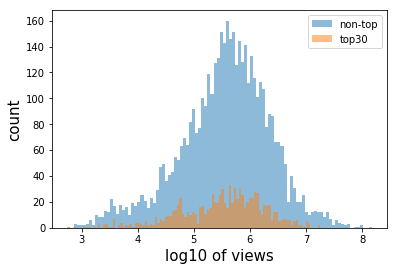

In [64]:
x1 = np.log10(top_d)
x2 = np.log10(non_top_d)
# x1 = (top_d)
# x2 = (non_top_d)
plt.hist(x2, label = 'non-top', alpha = 0.5, bins=100)
plt.hist(x1, label = 'top30', alpha = 0.5, bins=100)

plt.legend(loc = 'upper right')
plt.xlabel("log10 of views", fontsize=15)

plt.ylabel("count", fontsize=15)
plt.show()

It's not exactly clear from the graph which distribution has a higher mean. Let's calculate the mean from the data and run a t-test to tell if the difference is significant.

In [66]:
print('average views of videos that include the top 30 words:', top_d.mean())
print('average views of videos that do not include the top 30 words:', non_top_d.mean())
t_val, p_val = ttest_ind(top_d, non_top_d)
t_val, p_val

average views of videos that include the top 30 words: 979816.2245989305
average views of videos that do not include the top 30 words: 1570220.0578583765


(-3.4343834643240876, 0.000598238899911018)

It can be seen that the average views of those videos with popular words are actually less than those with not. After running the t-test, we can see the difference is actually quite significant. This means that while certain words such as "official", "trailer" appear more frequently than other in trending videos, using these words is actually correlated with less views among all the trending videos.

We now try to determine the average video lengths and title lengths of the most popular videos. We first define popular videos as those with more then 10 million views.

In [67]:
popular_videos = US_videos[US_videos['views'] > 10000000]

We plot the distribution of the lengths of popular videos and determine the average lengths. We also test to see if the lengths are normally distributed.

average length of popular videos (in seconds): 303.4


NormaltestResult(statistic=175.7153509293746, pvalue=6.98065786323699e-39)

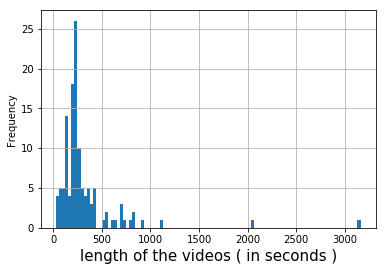

In [68]:
popular_videos[popular_videos['total_time'] != 0]['total_time'].plot.hist(bins= 100,grid=True)
plt.xlabel("length of the videos ( in seconds )", fontsize=15)
print('average length of popular videos (in seconds):', popular_videos['total_time'].mean())
normaltest(popular_videos['total_time'])

It turns out the distribution is not normally distributed. //TODO explain 
The average length of the videos is about 5 minutes.

We then plot the distribution of the title lengths of popular videos and determine the average lengths of the titles. We also test to see if the lengths are normally distributed.

average title length of popular videos (in number of characters): 44.16923076923077


NormaltestResult(statistic=12.796253046636602, pvalue=0.001664673079764679)

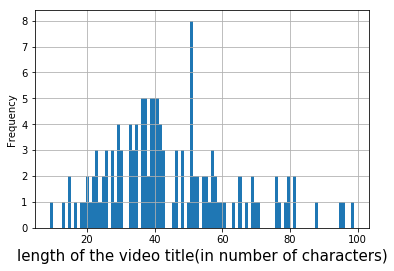

In [69]:
popular_videos['title_length'].plot.hist(bins= 100,grid=True)
plt.xlabel("length of the video title(in number of characters)", fontsize=15)
print('average title length of popular videos (in number of characters):', popular_videos['title_length'].mean())
normaltest(popular_videos['title_length'])

It turns out the distribution is not normally distributed. //TODO explain 
The average length of the videos is about 44 characters.

# Ethics & Privacy

Youtubers may exploit this dataset and our analysis to make content for the purpose of making money and gaining a large audience, possibly spreading false or useless information instead of sharing useful information. The social implications of such actions would be widespread; however it should still be noted that gaining a large following on YouTube isn't very easy.

The scope of the dataset may limit the accuracy of how the data reflects the popularity of YouTube videos in the real world, since the data we used only is representative of Trending videos in the US. Because of this, our analysis may be biased. 


# Conclusion & Discussion

- among the six months, the average length of the trending videos tends to go shorter.
- title lengths and views don't matter that much.
    - don't be too long 
    - when the lengths is shorter than 10 minutes, there's actually positive relation
- words like official trailer make it to the trending list more, but among the trending list videos, they actually have fewer views.


From our dataset, we decided to see if specific factors had any correlation or effect on the popularity and trending ability of YouTube Videos. We first concluded that due to the positive correlation between features such as number of views, comment count, and like count, we assume and define 'popularity' based on view count out of convenience for our data anaylsis process. 

We have found that among the 6 recent months of data studied, the average length of trending videos tend to be overall decreasing overtime; it is decreasing at a very slight, but still statistically significant, rate.



We looked at the actual content in YouTube Video titles and found that some of the most popular words used in titles include "official" and "trailer". However, among the list of trending videos, the videos that use "official" and "trailer" actually have less views but are still used the most overall. 

Videos that includes the most frequent words actually have less views comparing to other videos in the dataset. However, considering the dataset is based on YouTube’s trending list which automatically promotes trending videos to target audiences. Though including the top words from the word cloud does not ensure a video to be the top clicked videos, it does give us a hint of what contents have a better chance to be on YouTube’s trending list. Therefore, they have the chance to gain a larger view counts given YouTube’s trending list mechanism.